<a href="https://colab.research.google.com/github/mvakhmenin/MindSet/blob/main/Mind_set_%D0%AD%D0%BA%D1%81%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%86%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%81%D0%B3%D0%BB%D0%B0%D0%B6%D0%B8%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7_%D1%86%D0%B5%D0%BD_%D0%BD%D0%B0_%D0%B1%D0%B5%D1%82%D0%BE%D0%BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Mind-set - Экспоненциальное сглаживание - Прогноз цен на бетон</h1>

In [ ]:
pip install yadisk # документация - https://yadisk.readthedocs.io/

     |████████████████████████████████| 48 kB 3.7 MB/s 


In [ ]:
import yadisk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
import calendar
import datetime as dt

In [ ]:
y = yadisk.YaDisk(token="xxxxx")

# Check if the token is valid
if y.check_token():
  print('Токен работает')
else: 
  print('Какая-то проблема с токеном, получаем новый токен')
  # Ниже указываются ID и Пароль, которые можно получить по ссылке https://oauth.yandex.ru/ 
  # для приложения: GoogleColab-YandexDisk
  y = yadisk.YaDisk("xxxxx", "xxxxx")
  url = y.get_code_url()

  print("Go to the following url: %s" % url)
  code = input("Enter the confirmation code: ")

  try:
      response = y.get_token(code)
  except yadisk.exceptions.BadRequestError:
      print("Bad code")
      sys.exit(1)

  y.token = response.access_token

  if y.check_token():
    print("Sucessfully received token!")
  else:
      print("Something went wrong. Not sure how though...")

Какая-то проблема с токеном, получаем новый токен
Go to the following url: https://oauth.yandex.ru/authorize?response_type=code&client_id=805fcf6bb2ee4d35bae767e44044574e&display=popup&force_confirm=yes
Enter the confirmation code: 8144691
Sucessfully received token!


<h2>Скачивание и подготовка данных</h2>

In [ ]:
# Скачиваем данные с Яндекс.диска
files = ['prices2017-2021.csv']
for f in files:
  y.download("/"+f, f)

In [ ]:
# Очищаем данные и исправляем типы данных
import pandas as pd
df_init = pd.read_csv('prices2017-2021.csv', 
                      sep=';', 
                      usecols=[0, 1, 2, 3, 4, 5], 
                      skiprows=1,
                      header=0,
                      names=['Dates', 'Sand', 'Stone', 'Concreat', 'Electricity', 'Cement'])

In [ ]:
df_init.Sand = df_init.Sand.apply(lambda x: str(x).replace(',', '.'))
df_init.Stone = df_init.Stone.apply(lambda x: str(x).replace(',', '.'))
df_init.Concreat = df_init.Concreat.apply(lambda x: str(x).replace(',', '.'))
df_init.Electricity = df_init.Electricity.apply(lambda x: str(x).replace(',', '.'))
df_init.Cement = df_init.Cement.apply(lambda x: str(x).replace(',', '.'))

df_init.Stone = df_init.Stone.apply(lambda x: str(x).replace(' ', ''))
df_init.Concreat = df_init.Concreat.apply(lambda x: str(x).replace(' ', ''))
df_init.Electricity = df_init.Electricity.apply(lambda x: str(x).replace(' ', ''))
df_init.Cement = df_init.Cement.apply(lambda x: str(x).replace(' ', ''))

df_init.Sand = pd.to_numeric(df_init.Sand)
df_init.Stone = pd.to_numeric(df_init.Stone)
df_init.Concreat = pd.to_numeric(df_init.Concreat)
df_init.Electricity = pd.to_numeric(df_init.Electricity)
df_init.Cement = pd.to_numeric(df_init.Cement)

In [ ]:
df_init.Dates = pd.to_datetime(df_init.Dates)
df_init.set_index('Dates', inplace=True)

In [ ]:
df_init.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55 entries, 2017-01-01 to 2021-07-01
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sand         55 non-null     float64
 1   Stone        55 non-null     float64
 2   Concreat     55 non-null     float64
 3   Electricity  55 non-null     float64
 4   Cement       55 non-null     float64
dtypes: float64(5)
memory usage: 2.6 KB


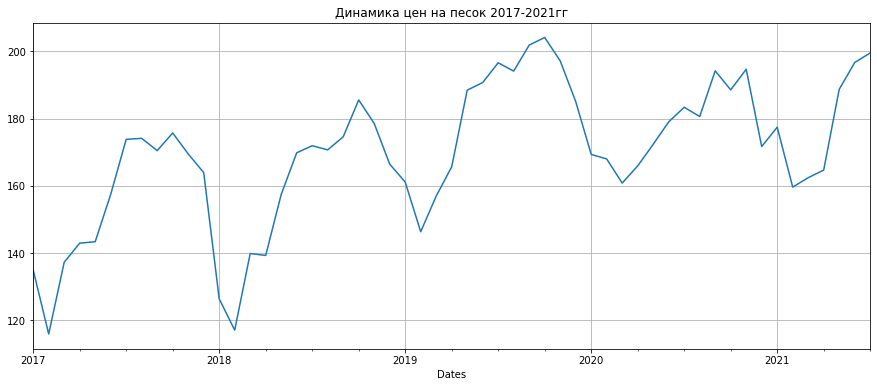

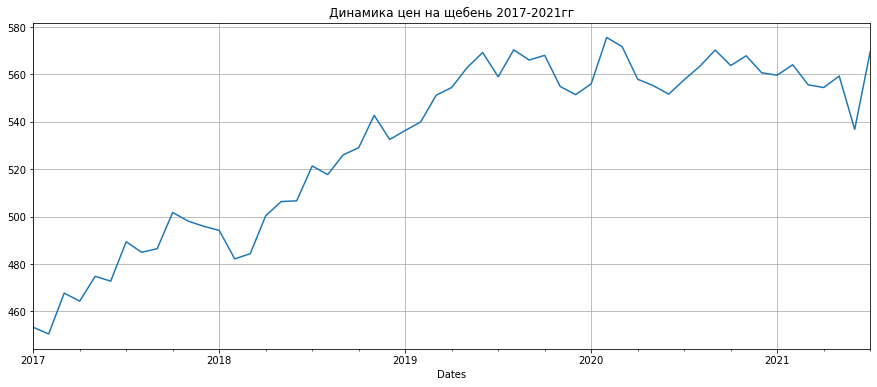

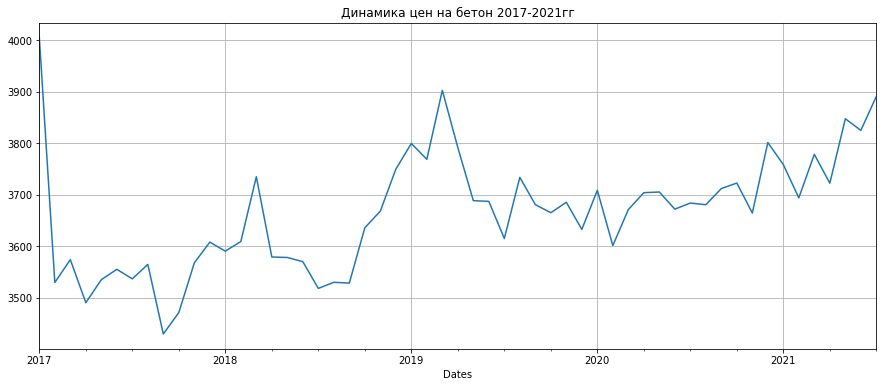

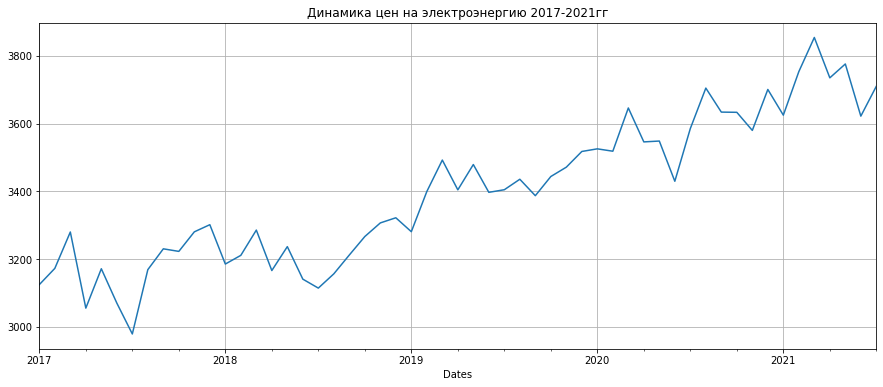

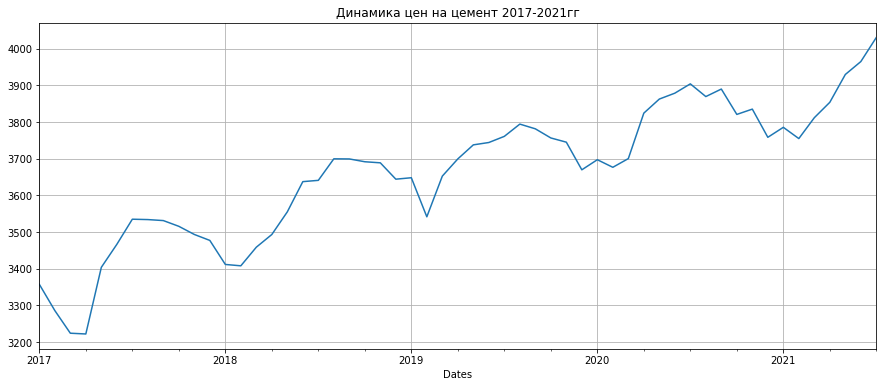

In [ ]:
# Строим графики всех временных рядов, чтобы визуально оценить данные 
df_init.Sand.plot(figsize=(15,6), grid=True, title='Динамика цен на песок 2017-2021гг')
plt.show()
df_init.Stone.plot(figsize=(15,6), grid=True, title='Динамика цен на щебень 2017-2021гг')
plt.show()
df_init.Concreat.plot(figsize=(15,6), grid=True, title='Динамика цен на бетон 2017-2021гг')
plt.show()
df_init.Electricity.plot(figsize=(15,6), grid=True, title='Динамика цен на электроэнергию 2017-2021гг')
plt.show()
df_init.Cement.plot(figsize=(15,6), grid=True, title='Динамика цен на цемент 2017-2021гг')
plt.show()

<h2>Экспоненциальное сглаживание</h2>
<h3>Простое экспоненциальное сглаживание</h3>
<p>Прогнозируемое значение представляет собой средневзвешенную между текущим истинным и предыдущим прогнозом. Вес $\alpha$ называется сглаживающим фактором. Он определяет, как быстро мы будем "забывать" последнее доступное истинное наблюдение. Чем меньше $\alpha$, тем больше влияния оказывают предыдущие прогнозы, и тем сильнее сглаживается ряд.</p>


<p>Экспоненциальность скрывается в рекурсивности функции — каждый раз мы умножаем $(1-\alpha)$ на предыдущий прогноз, который, в свою очередь, также содержал в себе $(1-\alpha)$, и так до самого начала.</p>

image.png

<p>При увеличении $\alpha$ последние значения временного ряда принимаются с большим весом.</p>
<p>Прогноз простого экспоненциального сглаживания - последнее сглаженное значение временного ряда</p>

In [ ]:
preds_period=6
materials = {'Песок': 'Sand', 
             'Щебень': 'Stone', 
             'Бетон': 'Concreat', 
             'Электроэнергия': 'Electricity', 
             'Цемент': 'Cement'}

def exponential_smoothing(series, alpha, n_preds):
    result = [series[0]] # Первый прогноз равняется первому значению временного ряда
    for n in range(1, len(series)+n_preds):
      # Следующее прогнозное значение является средневзвешенным между текущим истинным значением и предыдущем прогнозом
        if n < len(series):
          result.append(alpha * series[n] + (1 - alpha) * result[n-1])
        else: # Прогнозируем. Прогнозные значения = последнему сглаженному значению ряда, 
              # так как тренд и сезонность не учитываются
          result.append(alpha * result[n-1] + (1 - alpha) * result[n-1])
    return result

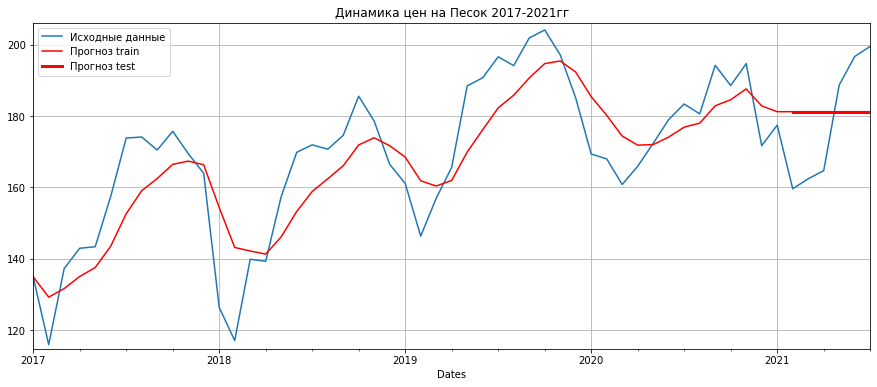

MAE Песок = 16.36
MAPE Песок = 9.35%


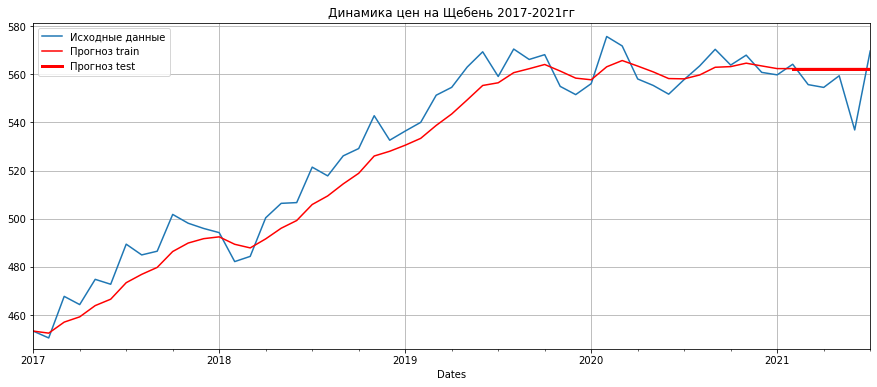

MAE Щебень = 8.67
MAPE Щебень = 1.58%


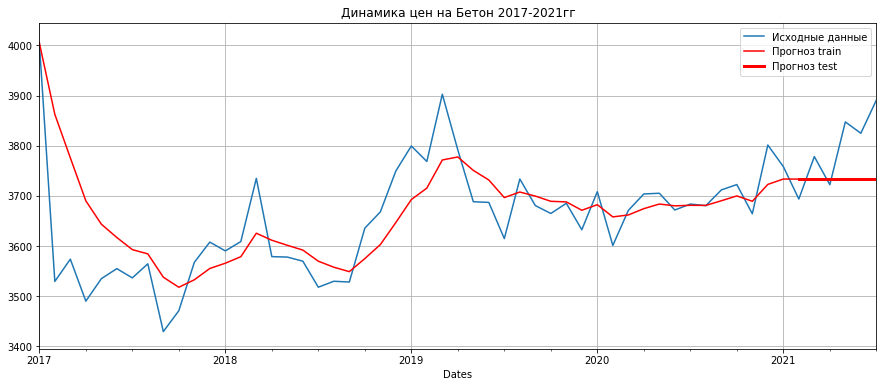

MAE Бетон = 76.38
MAPE Бетон = 1.99%


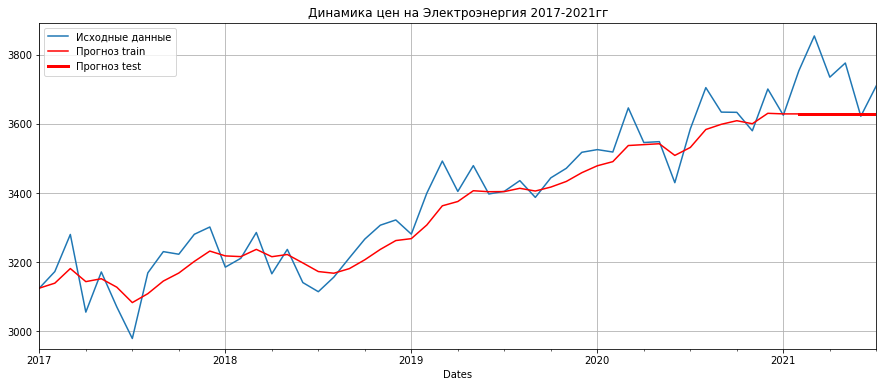

MAE Электроэнергия = 115.30
MAPE Электроэнергия = 3.05%


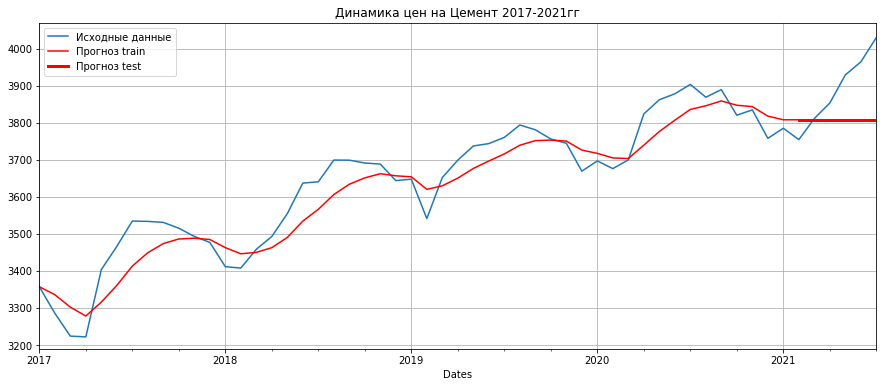

MAE Цемент = 100.32
MAPE Цемент = 2.54%


In [ ]:
for key in materials:
  df_init[materials[key]+'_1Spreds'] = exponential_smoothing(df_init[materials[key]][:-6], 0.3, n_preds=preds_period)
  df_init[materials[key]].plot(figsize=(15,6), ylim=(df_init[materials[key]].min()*0.99, df_init[materials[key]].max()*1.01), grid=True, title='Динамика цен на '+key+' 2017-2021гг', label='Исходные данные')
  df_init[materials[key]+'_1Spreds'].plot(figsize=(15,6), grid=True, label='Прогноз train', color = 'red')
  df_init[materials[key]+'_1Spreds'][-6:].plot(figsize=(15,6), grid=True, label='Прогноз test', linewidth = 3, color = 'red')
  plt.legend()
  plt.show()
  df_init[materials[key]+'_1Spreds_MAE'] = df_init[materials[key]] - df_init[materials[key]+'_1Spreds']
  df_init[materials[key]+'_1Spreds_MAPE'] = df_init[materials[key]+'_1Spreds_MAE'] / df_init[materials[key]]
  print(f'MAE {key} = {df_init[materials[key]+"_1Spreds_MAE"][-preds_period:].abs().mean():.2f}')
  print(f'MAPE {key} = {df_init[materials[key]+"_1Spreds_MAPE"][-preds_period:].abs().mean()*100:.2f}%')

<h3>Двойное экспоненциальное сглаживание</h3>
<p>Разбиение ряда на две составляющие — уровень (level, intercept) $\ell$ и тренд $b$ (trend, slope). Уровень, или ожидаемое значение ряда, мы предсказывали при помощи предыдущих методов, а теперь такое же экспоненциальное сглаживание применим к тренду.</p>

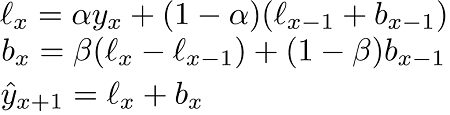

<p>

**Уровень (level)** - средневзвешенное значение между текущим истинным и предыдущим прогнозным значением, то есть фактически это простое экспоненциальное сглаживание.</p>
<p>

**Тренд (trend)** - средневзвешенное значение между текущим значением тренда (разница между текущим и предыдущим значением уровня) и предыдущим значеним тренда</p>
<p>

**Прогноз** - Сумма текущих значений уровня и тренда</p>

<p>Прогноз двойного экспоненциального сглаживания - последнее сглаженное значение временного ряда с учетом последнего значения сглаженного тренда</p>

In [ ]:
def double_exponential_smoothing(series, alpha, beta, n_preds):
    result = [series[0]]
    for n in range(1, len(series)+n_preds):
        if n == 1:
          # Задаем начальные значения уровня и тренда
          # Уровень - текущее истинное значение, тренд - разница между следующим истинным и текущим истинным занчениями
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
        # При прогнозировании вместо текущего истинного значения берем предыдущее значение прогноза
            value = result[-1]
        else:
            value = series[n]
        # Вычисляем уровень как средневзвешенное значение между текущим истинным и предыдущим прогнозным значением
        # (предыдущее прогнозное значение = сумма уровня и тренда)
        # текущее значение уровня предварительно сохраняем как предыдущее значение уровня
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        # Вычисляем тренд как средневзвешенное значение между текущим значением тренда (разница между текущим и предыдущим значением уровня) и предыдущим значеним тренда
        trend = beta*(level-last_level) + (1-beta)*trend
        # Получаем прогноз как сумму расчитанных уровня и тренда
        result.append(level+trend)
    return result

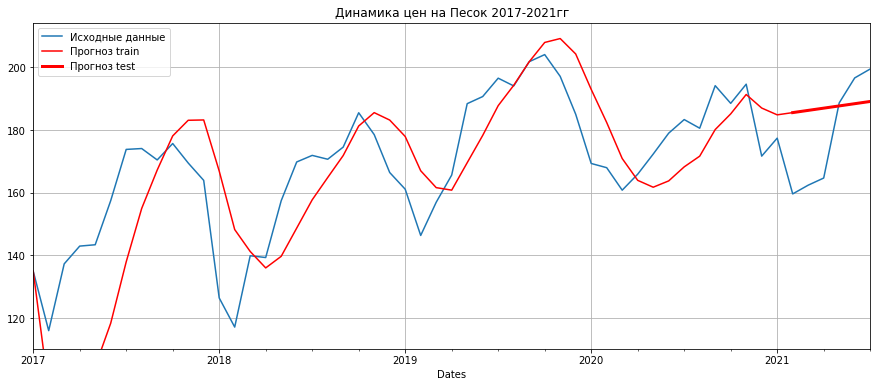

MAE Песок = 15.29
MAPE Песок = 9.07%


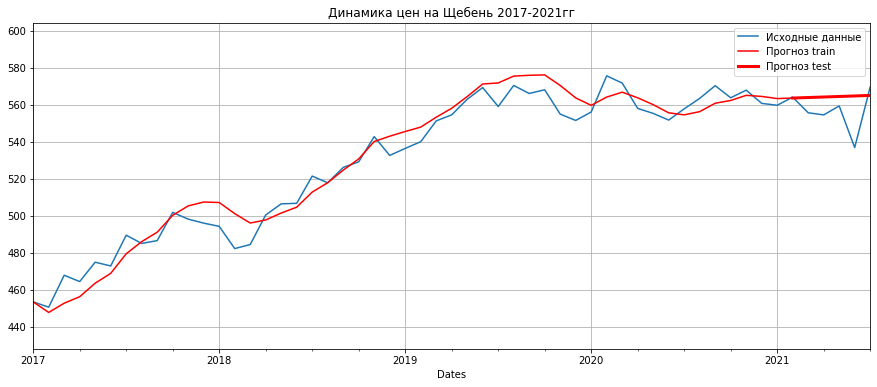

MAE Щебень = 9.34
MAPE Щебень = 1.71%


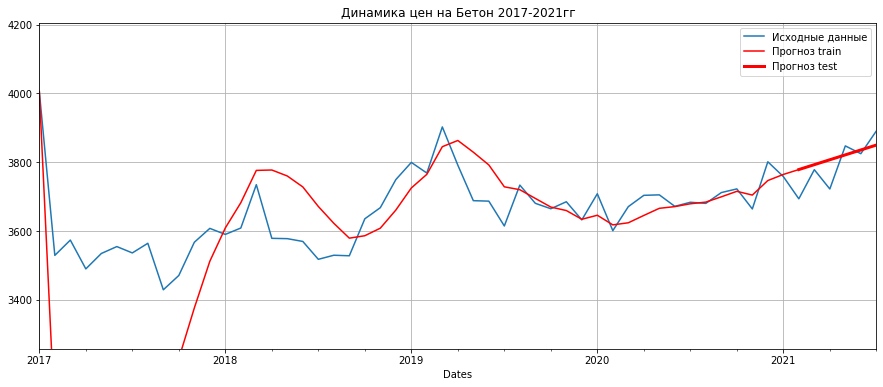

MAE Бетон = 43.72
MAPE Бетон = 1.16%


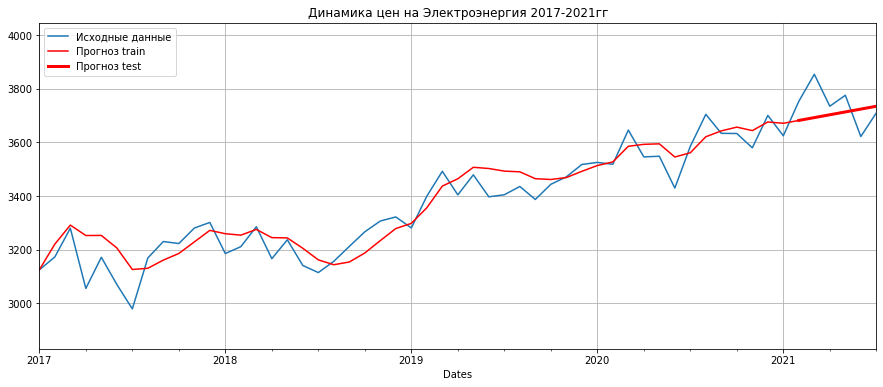

MAE Электроэнергия = 75.70
MAPE Электроэнергия = 2.01%


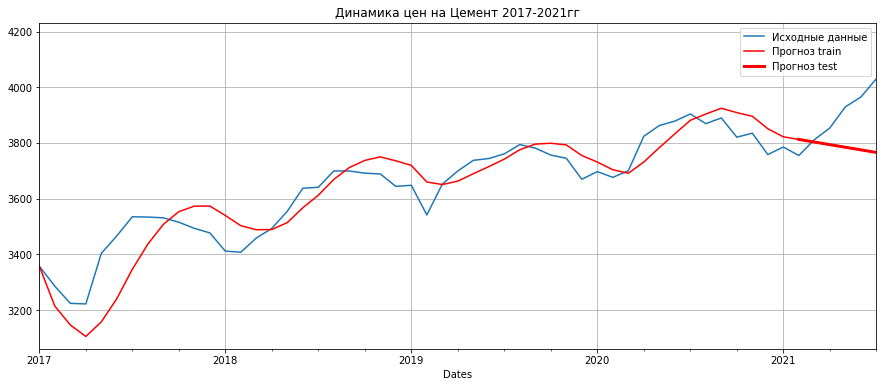

MAE Цемент = 120.85
MAPE Цемент = 3.06%


In [ ]:
for key in materials:
  df_init[materials[key]+'_2Spreds'] = double_exponential_smoothing(df_init[materials[key]][:-6], 0.3, 0.3, n_preds=preds_period)
  df_init[materials[key]].plot(figsize=(15,6), ylim=(df_init[materials[key]].min()*0.95, df_init[materials[key]].max()*1.05), grid=True, title='Динамика цен на '+key+' 2017-2021гг', label='Исходные данные')
  df_init[materials[key]+'_2Spreds'].plot(figsize=(15,6), grid=True, label='Прогноз train', color = 'red')
  df_init[materials[key]+'_2Spreds'][-6:].plot(figsize=(15,6), grid=True, label='Прогноз test', linewidth = 3, color = 'red')
  plt.legend()
  plt.show()
  df_init[materials[key]+'_2Spreds_MAE'] = df_init[materials[key]] - df_init[materials[key]+'_2Spreds']
  df_init[materials[key]+'_2Spreds_MAPE'] = df_init[materials[key]+'_2Spreds_MAE'] / df_init[materials[key]]
  print(f'MAE {key} = {df_init[materials[key]+"_2Spreds_MAE"][-preds_period:].abs().mean():.2f}')
  print(f'MAPE {key} = {df_init[materials[key]+"_2Spreds_MAPE"][-preds_period:].abs().mean()*100:.2f}%')

<h3>Тройное экспоненциальное сглаживание (Модель Хольта-Винтерса)</h3>
<p>Идея этого метода заключается в добавлении еще одной, третьей, компоненты — сезонности. Сезонная компонента в модели будет объяснять повторяющиеся колебания вокруг уровня и тренда, а характеризоваться она будет длиной сезона — периодом, после которого начинаются повторения колебаний. Уровень теперь зависит от текущего значения ряда за вычетом соответствующей сезонной компоненты, тренд остаётся без изменений, а сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты.</p>

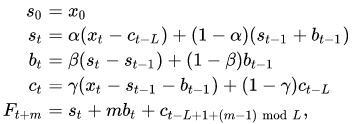

<p>

**Уровень (level, smooth)** - средневзвешенное значение между (разностью текущего истинного значени и сезонности) и (суммой предыдущего значения уровня и тренда). Первое значение уровня - первое значение фактических данных</p>
<p>

**Тренд (trend)** - средневзвешенное значение между текущим значением тренда (разница между текущим и предыдущим значением уровня) и предыдущим значеним тренда</p>
<p>

**Сезонность (seasonality)** - средневзвешенное значение между сезонностью за этот же период предыдущего года(разностью текущего истинного значени и уровня) и сезонностью за этот же период предыдущего года</p>
<p>

**Прогноз** - Сумма текущих значений уровня, тренда и сезонности</p>

In [ ]:
class HoltWinters:
 
    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf
 
    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
 
    """
 
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
 
    def initial_trend(self): # Расчитываем исходное значение тренда. 
                            # Оно будет использовано в цикле обучения-прогнозирования (triple_exponential_smoothing)
                            # для расчета первого значения тренда
        sum = 0.0
        for i in range(self.slen):
          # Берем истинное значение за первый месяц второго года 
          # минус истинное значение за первый месяц первого года и делим на количество месяцев
          # Считаем сумму таких значений пр всем месяцам. Получившуюся сумму опять делим на 12 месяцев и возвращаем
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
 
    def initial_seasonal_components(self): # Среднее значение сезонности по всем годам для каждого месяца
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen) # Определяем количество периодов сезонности
        # вычисляем сезонные средние
        for j in range(n_seasons):
  # Считаем среднемесячные фактические значения по каждому году (сумму фактических значений за год и делим на 12 месяцев)
            season_averages.append(self.series[self.slen*j:self.slen*j+self.slen].sum()/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
    # От фактического значения каждого месяца каждого года отнимаем среднее значение за этот год
    # Получаем сумму отклонений от среднего значения за год за январь всех лет, делим на количество лет
    # Получаем среднее значение сезонности (отклонение от среднего за год) за январи всех лет и так по всем месяцам.
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   
 
    def triple_exponential_smoothing(self): # Получаем фактические и прогнозные значения
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
 
        # Получаем исходные значения сезонности
        seasonals = self.initial_seasonal_components()
 
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент на первом шаге алгоритма
                smooth = self.series[0] # Первое значение уровня - первое значение фактических данных
                trend = self.initial_trend() # Первое значение тренда расчитываем функцией
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
 
                self.PredictedDeviation.append(0)
 
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
 
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
 
                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
 
                # Во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
 
            else: # Начиная со второго шага и до конца датасета минус горизон прогнозирования, считаем значения уровня, тренда и сезонности
                val = self.series[i]
                # Новое значение уровня
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                # Новое значение тренда
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                # Новое значение сезонности. Обновляем исходное значение сезонности в списке, сформированном функцией initial_seasonal_components()
                # В последующем используются не исходные, а пересчитанные значения сезонности
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                # Записываем прогноз
                self.result.append(smooth+trend+seasonals[i%self.slen])
 
                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
 
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])
 
            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])
 
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

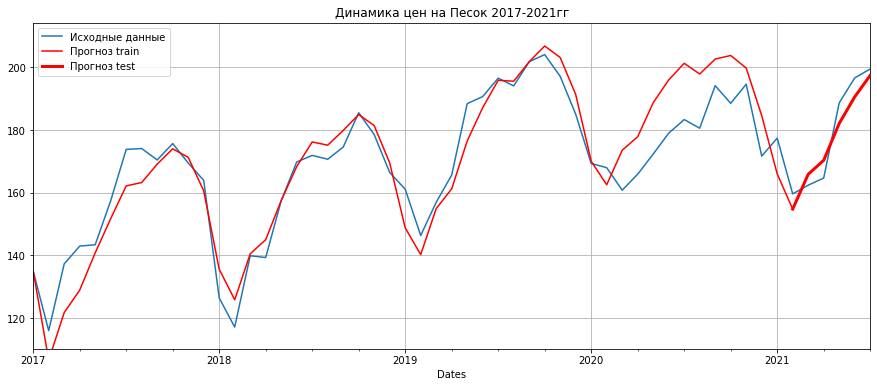

MAE Песок = 4.77
MAPE Песок = 2.70%


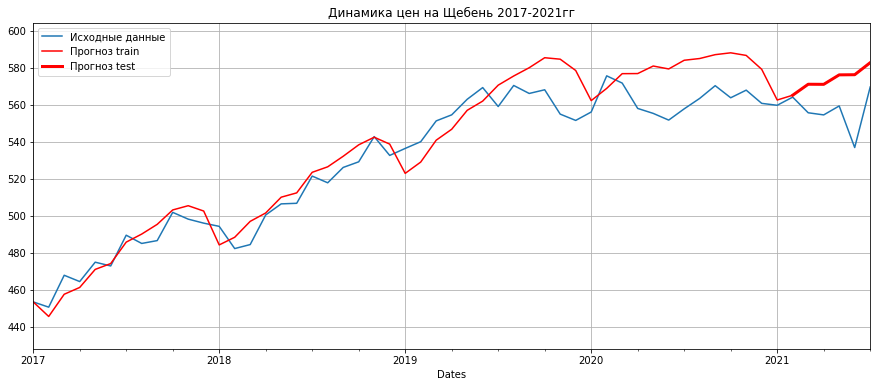

MAE Щебень = 17.06
MAPE Щебень = 3.10%


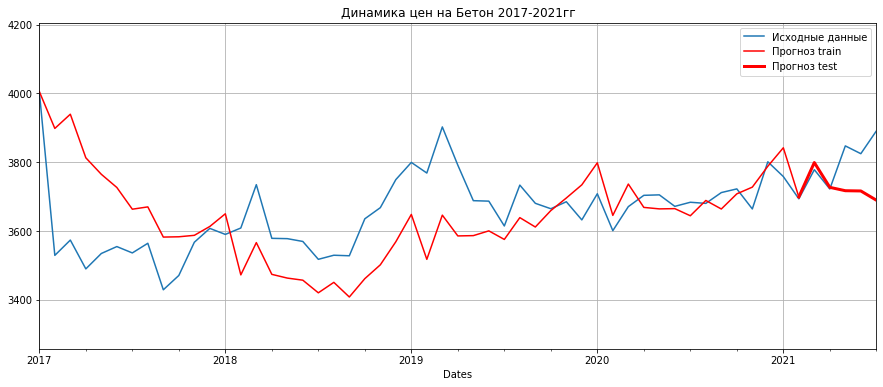

MAE Бетон = 78.40
MAPE Бетон = 2.03%


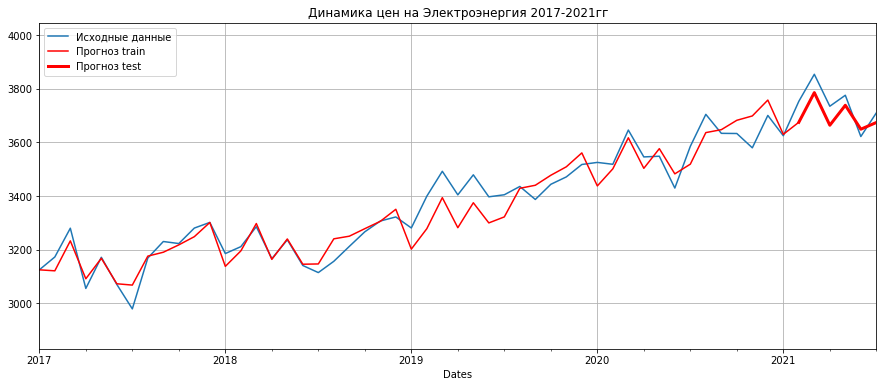

MAE Электроэнергия = 53.00
MAPE Электроэнергия = 1.41%


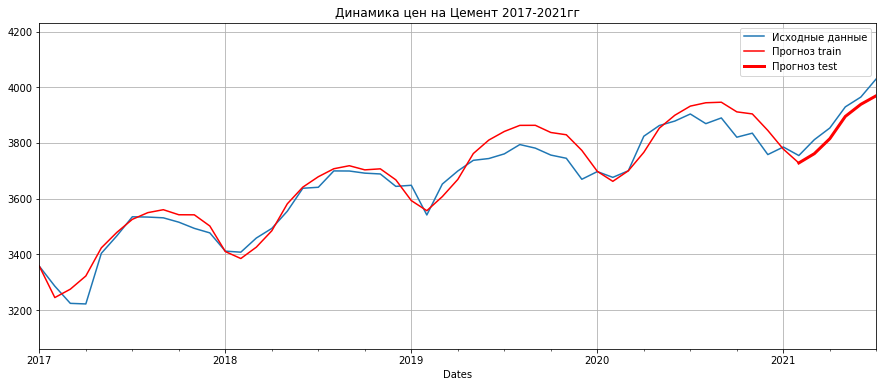

MAE Цемент = 39.39
MAPE Цемент = 1.01%


In [ ]:
for key in materials:
  model = HoltWinters(df_init[materials[key]][:-preds_period], 
                      slen = 12, 
                      alpha = 0.1, 
                      beta = 0.1, 
                      gamma = 0.1, 
                      n_preds = preds_period)
  model.triple_exponential_smoothing()
  df_init[materials[key]+'_HWpreds'] = model.result
  df_init[materials[key]].plot(figsize=(15,6), ylim=(df_init[materials[key]].min()*0.95, df_init[materials[key]].max()*1.05), grid=True, title='Динамика цен на '+key+' 2017-2021гг', label='Исходные данные')
  df_init[materials[key]+'_HWpreds'].plot(figsize=(15,6), grid=True, label='Прогноз train', color = 'red')
  df_init[materials[key]+'_HWpreds'][-preds_period:].plot(figsize=(15,6), grid=True, label='Прогноз test', linewidth = 3, color = 'red')
  plt.legend()
  plt.show()
  df_init[materials[key]+'_HWpreds_MAE'] = df_init[materials[key]] - df_init[materials[key]+'_HWpreds']
  df_init[materials[key]+'_HWpreds_MAPE'] = df_init[materials[key]+'_HWpreds_MAE'] / df_init[materials[key]]
  print(f'MAE {key} = {df_init[materials[key]+"_HWpreds_MAE"][-preds_period:].abs().mean():.2f}')
  print(f'MAPE {key} = {df_init[materials[key]+"_HWpreds_MAPE"][-preds_period:].abs().mean()*100:.2f}%')

<h2>Подбор параметров сглаживания</h2>


<h3>Двойное экспоненциальное сглаживание</h3>
Рассмотрим разные варианты оптимизации:

1. Минимизация абсолютной ошибки на тестовой выборке
2. Минимизация абсолюной ошибки на всем временном ряду
3. Минимизмация абослюной ошибки на обучающей и тестовой выборках, при этом влияние обучающей выборки снижается за счет ограничения ее продолжительности последним годом и делением абсолютной ошибки на количество последних периодов

**1. Минимизация абсолютной ошибки на тестовой выборке.**
Ошибка на тестовой выборке очень низкая, но ошбика на обучающей выборке очень большая. Полученная модель очень плохо описываем обучающую выборку

Оптимальные параметры - alpha: 0.111, beta: 0.348


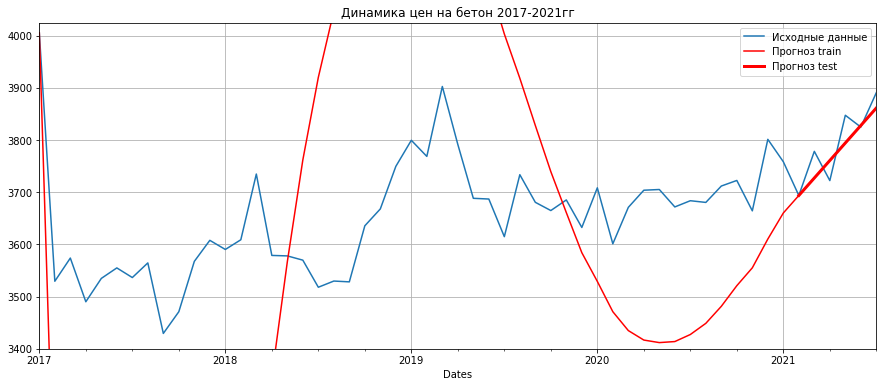

MAE test Бетон = 29.18
MAPE test Бетон = 0.77%
MAE train Бетон = 554.51
MAPE train Бетон = 15.43%


In [ ]:
def S2opimization(x):
  alpha, beta = x
  predictions = double_exponential_smoothing(df_init.Concreat[:-6], alpha=alpha, beta=beta, n_preds=preds_period)
  actual = df_init.Concreat

  return  mean_absolute_error(predictions[-6:], actual[-6:])

# инициализируем значения параметров
x = [0, 0] 

# Минимизируем функцию потерь (абсолютную ошибку) с ограничениями на параметры
opt = minimize(S2opimization, x0=x, method="TNC", bounds = ((0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_S2_final, beta_S2_final = opt.x
print(f'Оптимальные параметры - alpha: {alpha_S2_final:.3f}, beta: {beta_S2_final:.3f}')

df_init['Concreat_2Spreds'] = double_exponential_smoothing(df_init.Concreat[:-6], 
                                                           alpha = alpha_S2_final, 
                                                           beta = beta_S2_final, 
                                                           n_preds=preds_period)
df_init.Concreat.plot(figsize=(15,6),
                      ylim=(3400, 4025),
                      grid=True, 
                      title='Динамика цен на бетон 2017-2021гг', 
                      label='Исходные данные')
df_init['Concreat_2Spreds'].plot(figsize=(15,6), grid=True, label='Прогноз train', color = 'red')
df_init['Concreat_2Spreds'][-6:].plot(figsize=(15,6), grid=True, label='Прогноз test', linewidth = 3, color = 'red')
plt.legend()
plt.show()
df_init['Concreat_2Spreds_MAE'] = df_init['Concreat'] - df_init['Concreat_2Spreds']
df_init['Concreat_2Spreds_MAPE'] = df_init['Concreat_2Spreds_MAE'] / df_init['Concreat']
print(f'MAE test Бетон = {df_init["Concreat_2Spreds_MAE"][-preds_period:].abs().mean():.2f}')
print(f'MAPE test Бетон = {df_init["Concreat_2Spreds_MAPE"][-preds_period:].abs().mean()*100:.2f}%')
print(f'MAE train Бетон = {df_init["Concreat_2Spreds_MAE"][:-preds_period].abs().mean():.2f}')
print(f'MAPE train Бетон = {df_init["Concreat_2Spreds_MAPE"][:-preds_period].abs().mean()*100:.2f}%')

**2. Минимизация абсолюной ошибки на всем временном ряду**
Ошибка на тестовой выборке значительно выше, чем на обучающей выборке, то есть имеет место переобучение



Оптимальные параметры - alpha: 0.881, beta: 0.555


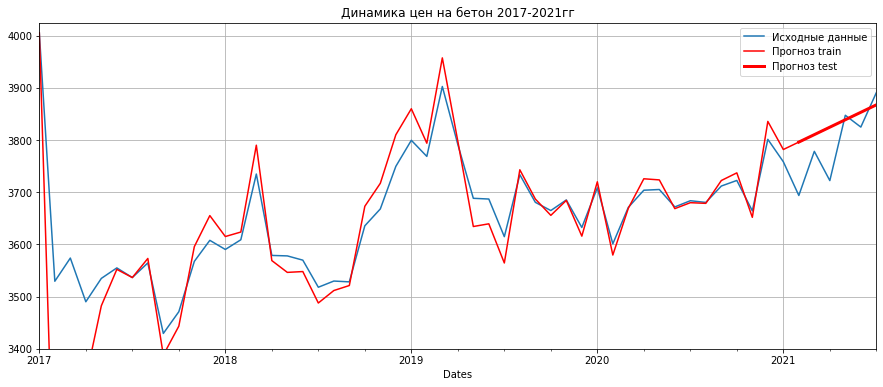

MAE test Бетон = 49.50
MAPE test Бетон = 1.32%
MAE train Бетон = 40.73
MAPE train Бетон = 1.13%


In [ ]:
def S2opimization(x):
  alpha, beta = x
  predictions = double_exponential_smoothing(df_init.Concreat[:-6], alpha=alpha, beta=beta, n_preds=preds_period)
  actual = df_init.Concreat

  return  mean_absolute_error(predictions, actual)

# инициализируем значения параметров
x = [0, 0] 

# Минимизируем функцию потерь (абсолютную ошибку) с ограничениями на параметры
opt = minimize(S2opimization, x0=x, method="TNC", bounds = ((0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_S2_final, beta_S2_final = opt.x
print(f'Оптимальные параметры - alpha: {alpha_S2_final:.3f}, beta: {beta_S2_final:.3f}')

df_init['Concreat_2Spreds'] = double_exponential_smoothing(df_init.Concreat[:-6], 
                                                           alpha = alpha_S2_final, 
                                                           beta = beta_S2_final, 
                                                           n_preds=preds_period)
df_init.Concreat.plot(figsize=(15,6),
                      ylim=(3400, 4025),
                      grid=True, 
                      title='Динамика цен на бетон 2017-2021гг', 
                      label='Исходные данные')
df_init['Concreat_2Spreds'].plot(figsize=(15,6), grid=True, label='Прогноз train', color = 'red')
df_init['Concreat_2Spreds'][-6:].plot(figsize=(15,6), grid=True, label='Прогноз test', linewidth = 3, color = 'red')
plt.legend()
plt.show()
df_init['Concreat_2Spreds_MAE'] = df_init['Concreat'] - df_init['Concreat_2Spreds']
df_init['Concreat_2Spreds_MAPE'] = df_init['Concreat_2Spreds_MAE'] / df_init['Concreat']
print(f'MAE test Бетон = {df_init["Concreat_2Spreds_MAE"][-preds_period:].abs().mean():.2f}')
print(f'MAPE test Бетон = {df_init["Concreat_2Spreds_MAPE"][-preds_period:].abs().mean()*100:.2f}%')
print(f'MAE train Бетон = {df_init["Concreat_2Spreds_MAE"][:-preds_period].abs().mean():.2f}')
print(f'MAPE train Бетон = {df_init["Concreat_2Spreds_MAPE"][:-preds_period].abs().mean()*100:.2f}%')

3. **Минимизмация абослюной ошибки на обучающей и тестовой выборках**, при этом влияние обучающей выборки снижается за счет ограничения ее продолжительности последним годом и делением абсолютной ошибки на количество последних периодов.

Ошибка на тестовой выборке ниже, чем на обущчающей, то есть переобучения нет. Ошибка на обучающей выборке не очень большая, то есть модель лучше описывает обучающую выборку, чем в варианте 1.

In [ ]:
def S2opimization(x):
  alpha, beta = x
  predictions = double_exponential_smoothing(df_init.Concreat[:-6], alpha=alpha, beta=beta, n_preds=preds_period)
  actual = df_init.Concreat

  return  mean_absolute_error(predictions[-18:-6], actual[-18:-6])/12 + mean_absolute_error(predictions[-6:], actual[-6:])

# инициализируем значения параметров
x = [0, 0] 

# Минимизируем функцию потерь (абсолютную ошибку) с ограничениями на параметры
opt = minimize(S2opimization, x0=x, method="TNC", bounds = ((0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_S2_final, beta_S2_final = opt.x
print(f'Оптимальные параметры - alpha: {alpha_S2_final:.3f}, beta: {beta_S2_final:.3f}')

Оптимальные параметры - alpha: 0.276, beta: 0.266


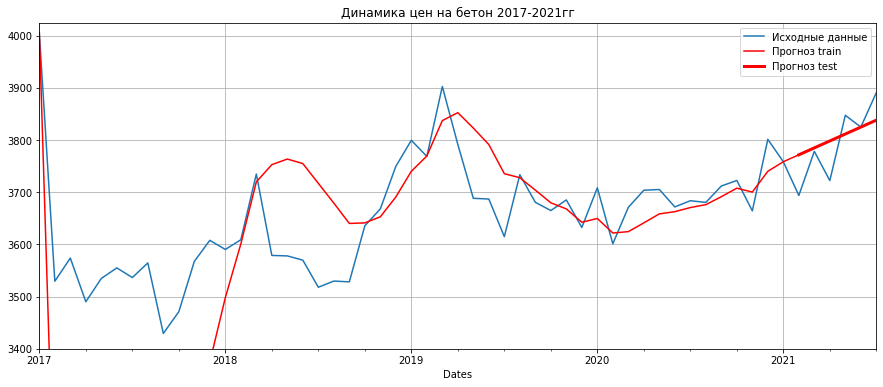

MAE test Бетон = 41.53
MAPE test Бетон = 1.10%
MAE train Бетон = 194.37
MAPE train Бетон = 5.47%


In [ ]:
df_init['Concreat_2Spreds'] = double_exponential_smoothing(df_init.Concreat[:-6], 
                                                           alpha = alpha_S2_final, 
                                                           beta = beta_S2_final, 
                                                           n_preds=preds_period)
df_init.Concreat.plot(figsize=(15,6),
                      ylim=(3400, 4025),
                      grid=True, 
                      title='Динамика цен на бетон 2017-2021гг', 
                      label='Исходные данные')
df_init['Concreat_2Spreds'].plot(figsize=(15,6), grid=True, label='Прогноз train', color = 'red')
df_init['Concreat_2Spreds'][-6:].plot(figsize=(15,6), grid=True, label='Прогноз test', linewidth = 3, color = 'red')
plt.legend()
plt.show()
df_init['Concreat_2Spreds_MAE'] = df_init['Concreat'] - df_init['Concreat_2Spreds']
df_init['Concreat_2Spreds_MAPE'] = df_init['Concreat_2Spreds_MAE'] / df_init['Concreat']
print(f'MAE test Бетон = {df_init["Concreat_2Spreds_MAE"][-preds_period:].abs().mean():.2f}')
print(f'MAPE test Бетон = {df_init["Concreat_2Spreds_MAPE"][-preds_period:].abs().mean()*100:.2f}%')
print(f'MAE train Бетон = {df_init["Concreat_2Spreds_MAE"][:-preds_period].abs().mean():.2f}')
print(f'MAPE train Бетон = {df_init["Concreat_2Spreds_MAPE"][:-preds_period].abs().mean()*100:.2f}%')

<h3>Тройное экспоненциальное сглаживание</h3>

In [ ]:
def HWoptimization(x):
  alpha, beta, gamma = x
  model = HoltWinters(df_init.Concreat[:-6], slen = 12, alpha=alpha, beta=beta, gamma=gamma, n_preds=6)
  model.triple_exponential_smoothing()

  predictions = model.result
  actual = df_init.Concreat

  return mean_absolute_error(predictions[-18:-6], actual[-18:-6])/12 + mean_absolute_error(predictions[-6:], actual[-6:])

In [ ]:
# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь (абсолютную ошибку) с ограничениями на параметры
opt = minimize(HWoptimization, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_HW_final, beta_HW_final, gamma_HW_final = opt.x
print(f'Оптимальные параметры - alpha: {alpha_HW_final:.3f}, beta: {beta_HW_final:.3f}, gamma: {gamma_HW_final:.3f}')

Оптимальные параметры - alpha: 0.083, beta: 0.000, gamma: 0.151


MAE = 80.27
MAPE = 2.08%


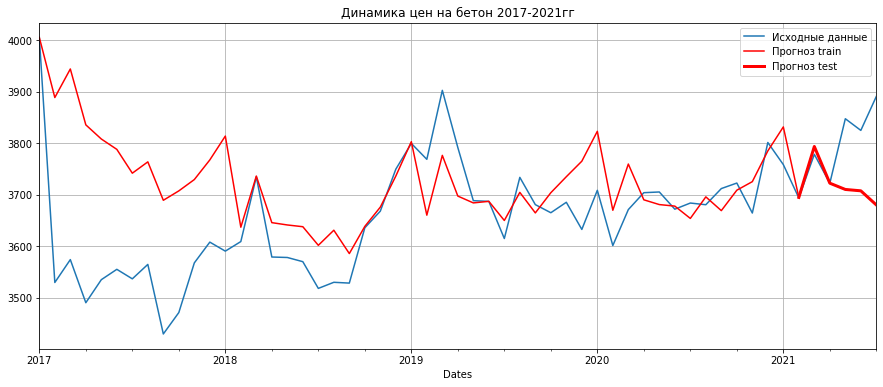

In [ ]:
model = HoltWinters(df_init.Concreat[:-6], slen = 12, alpha = alpha_HW_final, beta = beta_HW_final, gamma = gamma_HW_final, n_preds = 6)
preds_HW = model.triple_exponential_smoothing()
df_init['Concreat_HWpreds'] = model.result
df_init.Concreat.plot(figsize=(15,6), grid=True, title='Динамика цен на бетон 2017-2021гг', label='Исходные данные')
df_init.Concreat_HWpreds.plot(figsize=(15,6), grid=True, label='Прогноз train', color = 'red')
df_init.Concreat_HWpreds[-6:].plot(figsize=(15,6), grid=True, label='Прогноз test', linewidth = 3, color = 'red')
plt.legend()
df_init['Concreat_HWpreds_MAE'] = df_init['Concreat'] - df_init['Concreat_HWpreds']
df_init['Concreat_HWpreds_MAPE'] = df_init['Concreat_HWpreds_MAE'] / df_init['Concreat']
print(f'MAE = {df_init.Concreat_HWpreds_MAE[-preds_period:].abs().mean():.2f}')
print(f'MAPE = {df_init.Concreat_HWpreds_MAPE[-preds_period:].abs().mean()*100:.2f}%')

In [ ]:
df_means = df_init[-6:].abs().mean()

error_names = ['Простое сглаживание - Песок', 'Простое сглаживание - Щебень', 'Простое сглаживание - Бетон', 'Простое сглаживание - Электричество', 'Простое сглаживание - Цемент',
               'Двойное сглаживание - Песок', 'Двойное сглаживание - Щебень', 'Двойное сглаживание - Бетон', 'Двойное сглаживание - Электричество', 'Двойное сглаживание - Цемент',
               'Тройное сглаживание - Песок', 'Тройное сглаживание - Щебень', 'Тройное сглаживание - Бетон', 'Тройное сглаживание - Электричество', 'Тройное сглаживание - Цемент']
MAE_means = df_means[df_means.index.str.contains('MAE')].values
MAPE_means = df_means[df_means.index.str.contains('MAPE')].values

df_errors = pd.DataFrame(index=error_names, columns=['MAE', 'MAPE, %'])
df_errors['MAE'] = df_means[df_means.index.str.contains('MAE')].values
df_errors['MAPE, %'] = df_means[df_means.index.str.contains('MAPE')].values*100
df_errors

,MAE,"MAPE, %"
Простое сглаживание - Песок,16.355000,9.352993
Простое сглаживание - Щебень,8.665848,1.580062
Простое сглаживание - Бетон,76.381979,1.992357
Простое сглаживание - Электричество,115.302524,3.049502
Простое сглаживание - Цемент,100.320128,2.538348
Двойное сглаживание - Песок,15.287009,9.068801
Двойное сглаживание - Щебень,9.340170,1.706277
Двойное сглаживание - Бетон,41.534057,1.102622
Двойное сглаживание - Электричество,75.696491,2.014815
Двойное сглаживание - Цемент,120.847285,3.057694


Самая низка ошибка по бетону на тестовой выборке у модели Двойного экспоненциального сглаживания

<h2>Выбор лучшей модели в зависимости от результатов прогнозирования</h2>

* Создаем датафрейм с исходными ценами на бетон и прогнозами двойного и тройного экспоненциального сглаживания
* Выберем лучший прогноз среди двойного и тройного экспоненциального сглаживания (функция get_min_MAE)

In [ ]:
df_model_selection = pd.DataFrame(index=df_init.index[:-6])
df_model_selection['Values'] = df_init.Concreat[:-6]

modelHW = HoltWinters(df_model_selection.Values[:-6], 
                      slen = season_len, 
                      alpha = alpha_HW_final, 
                      beta = beta_HW_final, 
                      gamma = gamma_HW_final, 
                      n_preds = 6)
modelHW.triple_exponential_smoothing()

df_model_selection['HWpreds'] = modelHW.result
df_model_selection['2Spreds'] = double_exponential_smoothing(df_model_selection.Values[:-6], 
                                                           alpha = alpha_S2_final, 
                                                           beta = beta_S2_final, 
                                                           n_preds=preds_period)

def get_min_MAE(row):
  value, pred1, pred2 = row[0], row[1], row[2]
  if abs(value - pred1) > abs(value - pred2):
    return pred2
  else: return pred1

  return pred1

def get_next_month(date):
  days_in_month = calendar.monthrange(date.year, date.month)
  new_date = date + dt.timedelta(days=days_in_month[1])
  try: return dt.datetime.date(new_date)
  except: return new_date


df_model_selection['Best_pred'] = df_model_selection.apply(get_min_MAE, axis=1)

Сравним средние ошибки за последние 6 месяцев по каждому прогнозу. Будем прогнозировать на следующие 6 месяцев с помощью той модели, у которой ошибка за предыдущие 6 месяцев меньше.

In [ ]:
if mean_absolute_error(df_model_selection.HWpreds[-6:].values, df_model_selection.Values[-6:].values) <= mean_absolute_error(df_model_selection['2Spreds'][-6:].values, df_model_selection.Values[-6:].values):
      modelHW = HoltWinters(df_model_selection.Values, 
                            slen = season_len, 
                            alpha = alpha_HW_final, 
                            beta = beta_HW_final, 
                            gamma = gamma_HW_final, 
                            n_preds = 6)
      modelHW.triple_exponential_smoothing()

      df_index = []
      for i in range(len(6)):
        df_index.append(get_next_month(df_model_selection.index[-1]))
      df_res = pd.DataFrame(model.result, index=df_index, columns=['Best_pred'])
      print(df_res)
      df_res.plot()
else:
  df_index = []
  for i in range(6):
    if i == 0:
      df_index.append(get_next_month(df_model_selection.index[-1]))
    else:
      df_index.append(get_next_month(df_index[-1]))
  df_res = pd.DataFrame(double_exponential_smoothing(df_model_selection.Values, 
                                alpha = alpha_S2_final, 
                                beta = beta_S2_final, 
                                n_preds=preds_period)[-6:], index=df_index, columns=['Best_pred'])
  
  df_res.reset_index(inplace=True)
  df_res['index'] = pd.to_datetime(df_res['index'])
  df_res.set_index('index', inplace=True)
  df_model_selection = df_model_selection.append(df_res)

Построим график, посчитаем ошибки на обучающей и тестовой выборках

MAE test Бетон = 41.53
MAPE test Бетон = 1.10%
MAE train Бетон = 81.39
MAPE train Бетон = 2.28%


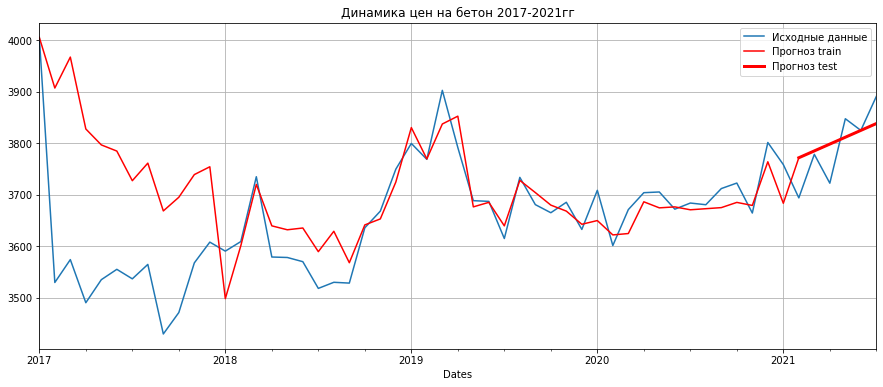

In [ ]:
df_init.Concreat.plot(figsize=(15,6), grid=True, title='Динамика цен на бетон 2017-2021гг', label='Исходные данные')
df_model_selection.Best_pred.plot(figsize=(15,6), grid=True, label='Прогноз train', color = 'red')
df_model_selection.Best_pred[-6:].plot(figsize=(15,6), grid=True, label='Прогноз test', linewidth = 3, color = 'red')
plt.legend()

df_model_selection['MAE'] = df_init.Concreat - df_model_selection['Best_pred']
df_model_selection['MAPE'] = df_model_selection['MAE'] / df_init.Concreat
print(f'MAE test Бетон = {df_model_selection["MAE"][-preds_period:].abs().mean():.2f}')
print(f'MAPE test Бетон = {df_model_selection["MAPE"][-preds_period:].abs().mean()*100:.2f}%')
print(f'MAE train Бетон = {df_model_selection["MAE"][:-preds_period].abs().mean():.2f}')
print(f'MAPE train Бетон = {df_model_selection["MAPE"][:-preds_period].abs().mean()*100:.2f}%')

Ошибка на тестовой выборке ожидаемо равна лучшему результату предыдущих этапов (двойное экспоненциальное сглаживание). При этом ошибка на обучающей выборке стала значительно ниже за счет выбора лучшего прогноза за каждый месяц.
Для построения прогноза на новый период, необходимо добавить в исходные данные фактическое значение за предыдущий месяц с сайта Росстата и перезапустить код. 

http://www.machinelearning.ru/wiki/images/e/ec/Psad_ts_ets.pdf<br>
https://nagornyy.me/it/regressionnye-modeli-v-python/